# ASSIGNMENT 4-2

In [1]:
%matplotlib widget

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import gymnasium as gym
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Video 


import warnings
warnings.filterwarnings('ignore')

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

cwd = os.getcwd()
NUM_ACTION = env.action_space.n
NUM_STATE = env.observation_space.n

# Generate a random seed
rng = jax.random.PRNGKey(seed=10)
# Use the random seed to generate a sequence of random seeds
rngs = hk.PRNGSequence(rng)
# A new random seed is obtained by calling next(rngs)

## 2-a

### Definition of main useful functions

In [4]:
def policy_network(s: jnp.ndarray) -> jnp.ndarray:
    """Policy network."""
    return hk.Sequential([
        hk.Linear(NUM_ACTION, w_init=jnp.zeros, with_bias=False), # Initialize weights to 1
        jax.nn.softmax  # Convert to probability distribution
    ])(s)

def value_network(s: jnp.ndarray) -> jnp.ndarray:
    """Value network."""
    return hk.Sequential([
        hk.Linear(1, w_init=jnp.zeros, with_bias=False), # Initialize weights to 0
        jnp.ravel  # Flatten to scalar
    ])(s)

pi_transformed = hk.without_apply_rng(hk.transform(policy_network)) # Transform policy network with Haiku
vf_transformed = hk.without_apply_rng(hk.transform(value_network))  # Transform value network with Haiku

@jax.jit
def get_action_probs(params: dict, state: jnp.ndarray) -> jnp.ndarray: 
    """Get action probabilities for given state."""
    return pi_transformed.apply(params, jax.nn.one_hot(state, NUM_STATE))

@jax.jit
def get_state_value(params: dict, state: jnp.ndarray) -> jnp.ndarray:
    """Get estimated value for given state."""
    return vf_transformed.apply(params, jax.nn.one_hot(state, NUM_STATE)).squeeze()

@jax.jit
def action_log_prob(params: dict, state: jnp.ndarray, action: jnp.ndarray) -> jnp.ndarray:
    """Calculate log probability of taking specific action in state."""
    probs = get_action_probs(params, state)
    return jnp.log(probs[action])

@jax.jit
def compute_advantage(v_params: dict, state: jnp.ndarray, return_: float) -> jnp.ndarray:
    """Compute advantage using value function baseline."""
    return return_ - get_state_value(v_params, state)

# Gradient functions
policy_grad = jax.grad(action_log_prob)
value_grad = jax.grad(get_state_value)

#%% Parameter Update Rules
@jax.jit
def update_policy(params: dict, grads: dict, lr: float, delta_: float) -> dict:
    """Update policy parameters using policy gradient theorem."""
    return jax.tree_map(lambda p, g: p + lr * delta_ * g, params, grads)

@jax.jit
def update_value(params: dict, grads: dict, lr: float, delta: float) -> dict:
    """Update value function parameters using TD error."""
    return jax.tree_map(lambda p, g: p + lr * delta * g, params, grads)


<img src="img/assign-4/reinforce-algo.png" alt="alt text" style="width:15cm;"/>

In [5]:
# REINFORCE Algorithm
def reinforce(
   pi_params: dict,
    vf_params: dict,
    rngs: hk.PRNGSequence,
    gamma: float = 0.99,
    pi_lr: float = 1e-4,
    vf_lr: float = 1e-3,
    episodes: int = 3000,
    env: gym.Env = env,
    algorithm:str ='reinforce_MC', #['reinforce_MC', 'reinforce_TD']
    use_baseline: bool = True
) -> tuple[dict, dict, list]:
    """
    REINFORCE algorithm with optional value function baseline.
    
    Args:
        pi_params: Initial policy parameters
        vf_params: Initial value function parameters
        rng: JAX random key
        gamma: Discount factor
        pi_lr: Policy learning rate
        vf_lr: Value function learning rate
        episodes: Number of training episodes
        env: Environment to train on
        use_baseline: Whether to use value function baseline
        
    Returns:
        tuple: (Final policy params, Final value params, Reward history)
    """
    reward_history = []
    
    pbar = tqdm(range(episodes))

    for _ in pbar:
        # Episode data collection
        episode_data = []
        state, _ = env.reset()
        
        # Generate trajectory
        while True:
            # Get action probabilities and sample action
            action_probs = get_action_probs(pi_params, state)
            action = jax.random.choice(next(rngs), NUM_ACTION, p=action_probs)
            
            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(int(action))
            done = terminated or truncated
            
            # Store transition
            episode_data.append((state, action, reward, next_state, done))
            
            if algorithm == 'reinforce_TD':
                # Get state and next state values
                state_value = get_state_value(vf_params, state)
                next_state_value = get_state_value(vf_params, next_state) if not done else 0.0
                
                # TD-error - advantage
                advantage = reward + gamma * next_state_value - state_value
                
                # Gradient calculation
                pi_grad = policy_grad(pi_params, state, action)
                vf_grad = value_grad(vf_params, state)
                
                # Update parameters
                pi_params = update_policy(pi_params, pi_grad, pi_lr, advantage)
                vf_params = update_value(vf_params, vf_grad, vf_lr, advantage)
            
            env.render()
            
            if done:
                break
            state = next_state

        if algorithm == 'reinforce_MC':
            # Calculate discounted returns
            states, actions, rewards, _, _ = zip(*episode_data)
            
            returns = []
            ret = 0.0
            for r in reversed(rewards):
                ret = r + gamma * ret
                returns.insert(0, ret)
            
            # Convert to JAX arrays
            states = jnp.array(states)
            actions = jnp.array(actions)
            returns = jnp.array(returns)

            # Update parameters for each step in episode
            for s, a, ret in zip(states, actions, returns):
                # Calculate gradients
                pi_grad = policy_grad(pi_params, s, a)
                
                if use_baseline:
                    # Calculate advantage and value gradient
                    delta = compute_advantage(vf_params, s, ret)
                    vf_grad = value_grad(vf_params, s)
                    
                    # Update parameters
                    pi_params = update_policy(pi_params, pi_grad, pi_lr, delta)
                    vf_params = update_value(vf_params, vf_grad, vf_lr, delta)
                else:
                    # Update without baseline
                    pi_params = update_policy(pi_params, pi_grad, pi_lr, ret)

        # Record episode performance
        rewards_ep =(sum(r for _, _, r, _, _ in episode_data))
        reward_history.append(rewards_ep)
        pbar.set_description(f"Episode Reward: {rewards_ep}")

    return pi_params, vf_params, reward_history


Tests of the following algorithms:

- REINFORCE with Monte Carlo algorithm baseline
- REINFORCE with Monte Carlo algorithm without baseline

Parameters:

gamma: float = 0.9  
pi_lr: float = 0.1  
vf_lr: float = 0.5  
episodes: int = 2000 

In [6]:
cwd = os.getcwd()
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video","4-2"), name_prefix="training-video", episode_trigger=lambda x: x % 50 == 0)

# Initialize networks
dummy_input = jax.nn.one_hot(0, NUM_STATE)  # One-hot encoded state

# Initialize parameters
pi_params_0 = pi_transformed.init(rng, dummy_input)
vf_params_0 = vf_transformed.init(rng, dummy_input)

pi_params = pi_params_0
vf_params = vf_params_0

# RUN TRAINING
MC_pi, MC_vf, MC_rewards = reinforce(
    gamma=0.9,
    pi_lr=0.1,
    vf_lr=0.5,
    episodes=2000,
    pi_params=pi_params_0, 
    vf_params=vf_params_0, 
    algorithm='reinforce_MC', 
    use_baseline=False, 
    rngs=rngs,) # Run training without baseline - MC

MC_pi_A, MC_vf_A, MC_rewards_A = reinforce(
    gamma=0.9,
    pi_lr=0.1,
    vf_lr=0.5,
    episodes=2000,
    pi_params=pi_params_0, 
    vf_params=vf_params_0, 
    algorithm='reinforce_MC', 
    use_baseline=True, 
    rngs=rngs,) # Run training with baseline - MC


Episode Reward: 1.0: 100%|██████████| 2000/2000 [00:46<00:00, 42.63it/s]


In [7]:
print("Final Policy Parameters:", MC_pi)
print("Final Value Function Parameters:", MC_vf)
print("Final Policy Parameters with Baseline:", MC_pi_A)
print("Final Value Function Parameters with Baseline:", MC_vf_A)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "4", "model_params_MC_lake.npz"),
#     policy_params=jax.device_get(MC_pi),
#     value_params=jax.device_get(MC_vf)
# )
# jnp.savez(
#     os.path.join(cwd, "saved_models", "4", "model_params_MC_A_lake.npz"),
#     policy_params=jax.device_get(MC_pi_A),
#     value_params=jax.device_get(MC_vf_A)
# )

Final Policy Parameters: {'linear': {'w': Array([[-0.29915783,  3.3040054 , -1.7767465 , -1.2281034 ],
       [ 0.22023132, -0.5155413 ,  0.39645493, -0.10114495],
       [-0.2896748 ,  0.6703368 , -0.24502707, -0.13563506],
       [ 0.24104877, -0.09866765, -0.09866765, -0.04371344],
       [-0.9110445 ,  3.6895268 , -1.9439486 , -0.83453554],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.48086938,  1.2556602 , -0.48086938, -0.29392147],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.10869752, -2.009723  ,  3.207988  , -1.0895644 ],
       [-1.391911  ,  2.7814553 ,  1.1015931 , -2.4911387 ],
       [-0.74817723,  3.4485412 , -1.590927  , -1.1094394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.8470778 , -0.537505  ,  2.8911686 , -0.50658786],
       [-1.6397815 , -1.1047081 ,  4.0535564 , -1.3090671 ],
       [ 0.        ,  0.        ,  0.      

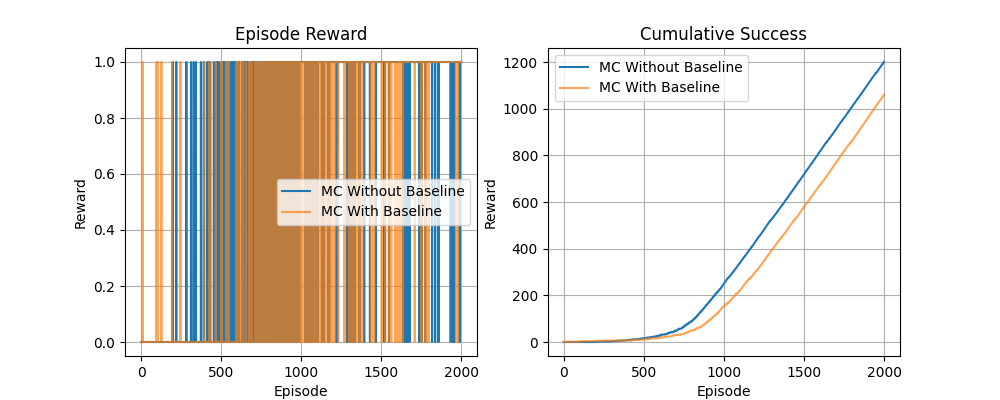

In [8]:
MC_cumulative_rewards = np.cumsum(MC_rewards)
MC_cumulative_rewards_A = np.cumsum(MC_rewards_A)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(MC_rewards, label='MC Without Baseline', alpha=1)
plt.plot(MC_rewards_A, label='MC With Baseline', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.subplot(1, 2, 2)
plt.plot(MC_cumulative_rewards, label='MC Without Baseline', alpha=1)
plt.plot(MC_cumulative_rewards_A, label='MC With Baseline', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Cumulative Success")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 2-b

In [9]:
def dnn_policy_network(s: jnp.ndarray) -> jnp.ndarray:
    """Policy network con inizializzazione che favorisce a=1."""
    return hk.Sequential([
        hk.Linear(2, w_init=jnp.zeros, with_bias=False), jax.nn.relu,
        hk.Linear(NUM_ACTION, w_init=jnp.zeros, with_bias=False),
        jax.nn.softmax
    ])(s)

pi_dnn = hk.without_apply_rng(hk.transform(dnn_policy_network))
pi_dnn_params = pi_dnn.init(rng, dummy_input)

@jax.jit
def get_action_probs(params: dict, state: jnp.ndarray) -> jnp.ndarray: 
    """Get action probabilities for given state."""
    return pi_dnn.apply(params, jax.nn.one_hot(state, NUM_STATE))

probs = pi_dnn.apply(pi_dnn_params, dummy_input)

print("Initial probability:", probs)
# Initialize parameters
dMC_pi, dMC_vf, dMC_rewards = reinforce(
    gamma=0.9,
    pi_lr=0.1,
    vf_lr=0.5,
    episodes=2000,
    pi_params=pi_dnn_params, 
    vf_params=vf_params_0, 
    algorithm='reinforce_MC', 
    use_baseline=True, 
    rngs=rngs,) # Run training with baseline - MC

Initial probability: [0.25 0.25 0.25 0.25]


Episode Reward: 0.0: 100%|██████████| 2000/2000 [00:54<00:00, 36.80it/s]


In [10]:
print("Final Policy Parameters:", dMC_pi)
print("Final Value Function Parameters:", dMC_vf)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "4", "model_params_dMC_lake.npz"),
#     policy_params=jax.device_get(dMC_pi),
#     value_params=jax.device_get(dMC_vf)
# )

Final Policy Parameters: {'linear': {'w': Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)}, 'linear_1': {'w': Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)}}
Final Value Function Parameters: {'linear': {'w': Array([[5.9021212e-38],
       [1.2939328e-12],
       [2.6566858e-07],
       [9.0727326e-07],
       [1.1619463e-36],
       [0.0000000e+00],
       [6.3392497e-03],
       [0.0000000e+00],
       [1.7283646e-14],
       [1.7005103e-03],
       [2.8195627e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [9.0831600e-02],
       [9.2196351e-01],
       [0.0000000e+00]], dtype=float32)}}


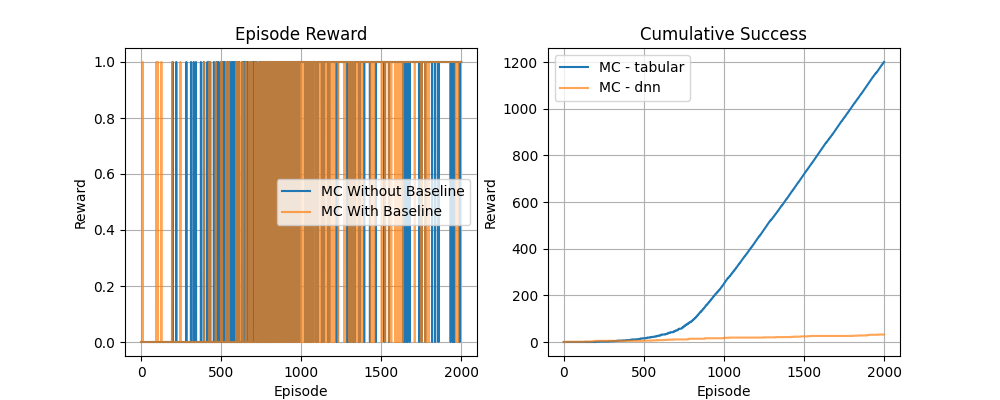

: 

In [ ]:
MC_cumulative_rewards = np.cumsum(MC_rewards)
dMC_cumulative_rewards = np.cumsum(dMC_rewards)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(MC_rewards, label='MC Without Baseline', alpha=1)
plt.plot(MC_rewards_A, label='MC With Baseline', alpha=0.7)
plt.legend()
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Reward")
plt.subplot(1, 2, 2)
plt.plot(MC_cumulative_rewards, label='MC - tabular', alpha=1)
plt.plot(dMC_cumulative_rewards, label='MC - dnn', alpha=0.7)
plt.legend()
plt.grid()
plt.title("Cumulative Success")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()